# Loading data

In [108]:
from sparksession import spark

df = spark.read.csv('../data/dataset/DataCoSupplyChainDataset.csv',header=True, inferSchema=True)

df.printSchema()


root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [109]:
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [110]:

from pyspark.sql import functions as f
df_cleaned = df.filter(f.col('Order Status') != 'CANCELED')
df_cleaned.filter(f.col('Order Status') =='CANCELED' ).count()

df_cleaned.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in df.columns]).show()
# Product Description,Order Zipcode have null values
# df_cleaned = df.drop('Order Zipcode', 'Product Description', 'Customer Email', 'Customer Password' )

df_cleaned = df_cleaned.withColumn(
    'Shipping Mode',
    f.when(f.col('Shipping Mode') == 'Same Day', 'First Class')
    .otherwise(f.col('Shipping Mode'))
)



+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [111]:
df_cleaned.show()



+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [112]:
columns_redondantes  = [
    # 'Type',
    'Days for shipping (real)',
    'Delivery Status',
    'Customer Fname',
    'Customer Lname',
    'Customer Email',
    'Customer Password',
    'Order Id',
    'Customer Id',
    'Order Item Id',
    'Order Customer Id',
    'Order Item Cardprod Id',
    'Product Card Id',
    'Product Category Id',
    'Department Id',
    'Product Description',
    'Product Image',
    'Product Name'  ,
    'Order Item Total',
    'Order Profit Per Order',
    'Benefit per order',
    'Sales per customer',
    'Order Item Profit Ratio',
    'Customer Country',
    'rder Zipcode',
    'Product Status',
    'Customer State',
    'Customer Street',
    'Customer Zipcode',
    'Department Name',
    'Latitude',
    'Longitude',
    'Market',
    'Order City',
    'Order Country',
    'Order Item Discount',
    'Order Item Discount Rate',
    'Order Item Product Price',
    # 'Order Item Quantity',
    'Sales',
    'Order Status',
    'Product Card Id',
    'Product Price'
    'Product Status',
    'Shipping date (DateOrders)',
    'Shipping Mode',
    'Category Name',
    'Customer City',
    'Order Zipcode',
    'Order State',
    'Product Price',
    
]


df_columns_cleaned =  df_cleaned.drop(*columns_redondantes)

df_columns_cleaned.show()

+--------+-----------------------------+------------------+-----------+----------------+-----------------------+-------------------+--------------+
|    Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|Customer Segment|order date (DateOrders)|Order Item Quantity|  Order Region|
+--------+-----------------------------+------------------+-----------+----------------+-----------------------+-------------------+--------------+
|   DEBIT|                            4|                 0|         73|        Consumer|        1/31/2018 22:56|                  1|Southeast Asia|
|TRANSFER|                            4|                 1|         73|        Consumer|        1/13/2018 12:27|                  1|    South Asia|
|    CASH|                            4|                 0|         73|        Consumer|        1/13/2018 12:06|                  1|    South Asia|
|   DEBIT|                            4|                 0|         73|     Home Office|        1/13/2018 11:45|

In [113]:
df_columns_cleaned = df_columns_cleaned.withColumn(
    'order_date',
    f.to_timestamp('order date (DateOrders)', "M/d/yyyy H:mm")
)

df_columns_cleaned = df_columns_cleaned.withColumn('order_month', f.month('order_date'))

df_columns_cleaned = df_columns_cleaned.drop('order date (DateOrders)', 'order_date')

df_columns_cleaned.show()

+--------+-----------------------------+------------------+-----------+----------------+-------------------+--------------+-----------+
|    Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|Customer Segment|Order Item Quantity|  Order Region|order_month|
+--------+-----------------------------+------------------+-----------+----------------+-------------------+--------------+-----------+
|   DEBIT|                            4|                 0|         73|        Consumer|                  1|Southeast Asia|          1|
|TRANSFER|                            4|                 1|         73|        Consumer|                  1|    South Asia|          1|
|    CASH|                            4|                 0|         73|        Consumer|                  1|    South Asia|          1|
|   DEBIT|                            4|                 0|         73|     Home Office|                  1|       Oceania|          1|
| PAYMENT|                            4|        

In [114]:
rslt_minor =df_columns_cleaned.filter(f.col('Late_delivery_risk') == 0)
rslt_major = df_columns_cleaned.filter(f.col('Late_delivery_risk') == 1)

print(rslt_minor.count(), rslt_major.count())


77850 98977


In [115]:
major_count = rslt_major.count()
minor_count = rslt_minor.count()

n_repeats = int(major_count / minor_count)

n_remainder = major_count % minor_count

# replicated_df = rslt_minor.withColumn(
#     "replicator",
#     f.explode(f.array([f.lit(i) for i in range(n_repeats)]))
# ).drop("replicator")

# replicated_df.count()

remainder_df = rslt_minor.orderBy(f.rand(seed=42)).limit(n_remainder)

balanced_df = rslt_major.unionAll(remainder_df)

balanced_df.groupBy("Late_delivery_risk").count().show()

+------------------+-----+
|Late_delivery_risk|count|
+------------------+-----+
|                 1|98977|
|                 0|21127|
+------------------+-----+



In [116]:
balanced_df.show()

+--------+-----------------------------+------------------+-----------+----------------+-------------------+--------------+-----------+
|    Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|Customer Segment|Order Item Quantity|  Order Region|order_month|
+--------+-----------------------------+------------------+-----------+----------------+-------------------+--------------+-----------+
|TRANSFER|                            4|                 1|         73|        Consumer|                  1|    South Asia|          1|
|   DEBIT|                            1|                 1|         73|     Home Office|                  1|  Eastern Asia|          1|
|TRANSFER|                            1|                 1|         73|       Corporate|                  1|  Eastern Asia|          1|
|    CASH|                            2|                 1|         73|       Corporate|                  1|  Eastern Asia|          1|
|    CASH|                            1|        

In [117]:
balanced_df.dtypes

[('Type', 'string'),
 ('Days for shipment (scheduled)', 'int'),
 ('Late_delivery_risk', 'int'),
 ('Category Id', 'int'),
 ('Customer Segment', 'string'),
 ('Order Item Quantity', 'int'),
 ('Order Region', 'string'),
 ('order_month', 'int')]

In [118]:
num_cols = []
cat_cols = []

for col, type in balanced_df.dtypes:
    if type in ['int', 'double'] :
        num_cols.append(col)
    else: 
        cat_cols.append(col)
        
        
cat_indexed = [
    'Customer Segment(indexed)',
    'Order Region(indexed)',
    'Type(indexed)'
    ]


cat_encoded = [    
    'Customer Segment(encoded)',
    'Order Region(encoded)',
    'Type(encoded)']

print(num_cols,cat_cols)


['Days for shipment (scheduled)', 'Late_delivery_risk', 'Category Id', 'Order Item Quantity', 'order_month'] ['Type', 'Customer Segment', 'Order Region']


In [119]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder

train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=42)


indexer = StringIndexer(inputCols=cat_cols, outputCols=cat_indexed)

encoder = OneHotEncoder(inputCols=cat_indexed, outputCols=cat_encoded)

assembler = VectorAssembler(inputCols=num_cols + cat_encoded, outputCol='features')

random_forest = RandomForestClassifier(labelCol='Late_delivery_risk', featuresCol='features')




In [120]:

df_with_index = balanced_df.rdd.zipWithIndex().toDF(["row", "index"])
df_test_selected = df_with_index.filter("index <= 3").select("row.*")
balanced_df = df_with_index.filter("index >= 3").select("row.*")

df_test_selected.show()

+--------+-----------------------------+------------------+-----------+----------------+-------------------+------------+-----------+
|    Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|Customer Segment|Order Item Quantity|Order Region|order_month|
+--------+-----------------------------+------------------+-----------+----------------+-------------------+------------+-----------+
|TRANSFER|                            4|                 1|         73|        Consumer|                  1|  South Asia|          1|
|   DEBIT|                            1|                 1|         73|     Home Office|                  1|Eastern Asia|          1|
|TRANSFER|                            1|                 1|         73|       Corporate|                  1|Eastern Asia|          1|
|    CASH|                            2|                 1|         73|       Corporate|                  1|Eastern Asia|          1|
+--------+-----------------------------+------------------+---

In [121]:


from pyspark.ml import Pipeline

pipline1 = Pipeline(stages=[indexer, encoder, assembler, random_forest])


model_rf = pipline1.fit(train_df)
preds1 = model_rf.transform(test_df)




In [122]:
preds1.show()

+----+-----------------------------+------------------+-----------+----------------+-------------------+---------------+-----------+-------------------------+---------------------+-------------+-------------------------+---------------------+---------------+--------------------+--------------------+--------------------+----------+
|Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|Customer Segment|Order Item Quantity|   Order Region|order_month|Customer Segment(indexed)|Order Region(indexed)|Type(indexed)|Customer Segment(encoded)|Order Region(encoded)|  Type(encoded)|            features|       rawPrediction|         probability|prediction|
+----+-----------------------------+------------------+-----------+----------------+-------------------+---------------+-----------+-------------------------+---------------------+-------------+-------------------------+---------------------+---------------+--------------------+--------------------+--------------------+----------+
|

In [123]:
log_reg = LogisticRegression(
    labelCol="Late_delivery_risk",
    featuresCol="features",
    maxIter=50
)

In [124]:
from pyspark.ml import Pipeline

pipline2 = Pipeline(stages=[indexer, encoder, assembler, log_reg])


model_lr = pipline2.fit(train_df)
preds2 = model_lr.transform(test_df)

In [125]:
preds2.show()

+----+-----------------------------+------------------+-----------+----------------+-------------------+---------------+-----------+-------------------------+---------------------+-------------+-------------------------+---------------------+---------------+--------------------+--------------------+--------------------+----------+
|Type|Days for shipment (scheduled)|Late_delivery_risk|Category Id|Customer Segment|Order Item Quantity|   Order Region|order_month|Customer Segment(indexed)|Order Region(indexed)|Type(indexed)|Customer Segment(encoded)|Order Region(encoded)|  Type(encoded)|            features|       rawPrediction|         probability|prediction|
+----+-----------------------------+------------------+-----------+----------------+-------------------+---------------+-----------+-------------------------+---------------------+-------------+-------------------------+---------------------+---------------+--------------------+--------------------+--------------------+----------+
|

In [126]:
gbt = GBTClassifier(labelCol="Late_delivery_risk", featuresCol="features", maxIter=50)

pipline3 = Pipeline(stages=[indexer, encoder, assembler, gbt])

model_gbt = pipline3.fit(train_df)
preds_gbt = model_gbt.transform(test_df)

# Évaluation et Comparaison des Modèles

Nous allons maintenant évaluer les performances des trois modèles (Random Forest, Logistic Regression, Gradient Boosting Tree) en utilisant diverses métriques de performance.

In [127]:
# Import des librairies nécessaires pour l'évaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [128]:
# Obtenir les prédictions pour les trois modèles
print("=== Prédictions Random Forest ===")
preds_rf = model_rf.transform(test_df)
preds_rf.select("Late_delivery_risk", "prediction", "probability").show(10)

print("\n=== Prédictions Logistic Regression ===")
preds_lr = model_lr.transform(test_df)
preds_lr.select("Late_delivery_risk", "prediction", "probability").show(10)

print("\n=== Prédictions Gradient Boosting Tree ===")
preds_gbt = model_gbt.transform(test_df)
preds_gbt.select("Late_delivery_risk", "prediction", "probability").show(10)

=== Prédictions Random Forest ===
+------------------+----------+--------------------+
|Late_delivery_risk|prediction|         probability|
+------------------+----------+--------------------+
|                 1|       1.0|[0.05761949074180...|
|                 1|       1.0|[0.04892672365487...|
|                 1|       1.0|[0.05878906835366...|
|                 1|       1.0|[0.04741929777336...|
|                 1|       1.0|[0.05493828333624...|
|                 1|       1.0|[0.04722747977776...|
|                 1|       1.0|[0.04873490565927...|
|                 1|       1.0|[0.04873490565927...|
|                 1|       1.0|[0.05742767274620...|
|                 1|       1.0|[0.04336550233914...|
+------------------+----------+--------------------+
only showing top 10 rows


=== Prédictions Logistic Regression ===
+------------------+----------+--------------------+
|Late_delivery_risk|prediction|         probability|
+------------------+----------+--------------------

In [129]:
# Fonction pour calculer les métriques de confusion matrix
def calculate_confusion_metrics(predictions_df):
    """
    Calcule les métriques à partir d'un DataFrame de prédictions PySpark
    """
    # Conversion en Pandas pour faciliter les calculs
    pdf = predictions_df.select("Late_delivery_risk", "prediction").toPandas()
    
    # Calcul des métriques de confusion matrix
    tp = len(pdf[(pdf['Late_delivery_risk'] == 1) & (pdf['prediction'] == 1)])
    tn = len(pdf[(pdf['Late_delivery_risk'] == 0) & (pdf['prediction'] == 0)])
    fp = len(pdf[(pdf['Late_delivery_risk'] == 0) & (pdf['prediction'] == 1)])
    fn = len(pdf[(pdf['Late_delivery_risk'] == 1) & (pdf['prediction'] == 0)])
    
    # Calcul des métriques
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy, 'Precision': precision, 
        'Recall': recall, 'F1-Score': f1_score
    }

In [130]:
# Évaluation avec les métriques PySpark intégrées
def evaluate_model_pyspark(predictions_df, model_name):
    """
    Évalue un modèle avec les evaluators PySpark
    """
    print(f"\n=== Évaluation {model_name} ===")
    
    # Accuracy
    accuracy_evaluator = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", 
        predictionCol="prediction", 
        metricName="accuracy"
    )
    accuracy = accuracy_evaluator.evaluate(predictions_df)
    
    # Precision
    precision_evaluator = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", 
        predictionCol="prediction", 
        metricName="weightedPrecision"
    )
    precision = precision_evaluator.evaluate(predictions_df)
    
    # Recall
    recall_evaluator = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", 
        predictionCol="prediction", 
        metricName="weightedRecall"
    )
    recall = recall_evaluator.evaluate(predictions_df)
    
    # F1-Score
    f1_evaluator = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", 
        predictionCol="prediction", 
        metricName="f1"
    )
    f1 = f1_evaluator.evaluate(predictions_df)
    
    # AUC-ROC
    auc_evaluator = BinaryClassificationEvaluator(
        labelCol="Late_delivery_risk", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderROC"
    )
    auc_roc = auc_evaluator.evaluate(predictions_df)
    
    # AUC-PR (Area Under Precision-Recall curve)
    auc_pr_evaluator = BinaryClassificationEvaluator(
        labelCol="Late_delivery_risk", 
        rawPredictionCol="rawPrediction", 
        metricName="areaUnderPR"
    )
    auc_pr = auc_pr_evaluator.evaluate(predictions_df)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    }
    
    for metric, value in results.items():
        if metric != 'Model':
            print(f"{metric}: {value:.4f}")
    
    return results

In [131]:
# Évaluation des trois modèles
results_rf = evaluate_model_pyspark(preds_rf, "Random Forest")
results_lr = evaluate_model_pyspark(preds_lr, "Logistic Regression") 
results_gbt = evaluate_model_pyspark(preds_gbt, "Gradient Boosting Tree")

# Création d'un DataFrame comparatif
comparison_df = pd.DataFrame([results_rf, results_lr, results_gbt])
print("\n=== Comparaison des Modèles ===")
print(comparison_df.round(4))


=== Évaluation Random Forest ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
AUC-PR: 1.0000

=== Évaluation Logistic Regression ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
AUC-PR: 1.0000

=== Évaluation Gradient Boosting Tree ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
AUC-PR: 1.0000

=== Comparaison des Modèles ===
                    Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  \
0           Random Forest       1.0        1.0     1.0       1.0      1.0   
1     Logistic Regression       1.0        1.0     1.0       1.0      1.0   
2  Gradient Boosting Tree       1.0        1.0     1.0       1.0      1.0   

   AUC-PR  
0     1.0  
1     1.0  
2     1.0  


In [132]:
# Matrice de confusion détaillée pour chaque modèle
print("=== Matrices de Confusion ===")

models_data = [
    ("Random Forest", preds_rf),
    ("Logistic Regression", preds_lr), 
    ("Gradient Boosting Tree", preds_gbt)
]

confusion_results = []

for model_name, preds in models_data:
    print(f"\n--- {model_name} ---")
    metrics = calculate_confusion_metrics(preds)
    metrics['Model'] = model_name
    confusion_results.append(metrics)
    
    print(f"TP: {metrics['TP']}, TN: {metrics['TN']}, FP: {metrics['FP']}, FN: {metrics['FN']}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")

# DataFrame comparatif avec métriques détaillées
detailed_comparison = pd.DataFrame(confusion_results)
print("\n=== Comparaison Détaillée ===")
print(detailed_comparison[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']].round(4))

=== Matrices de Confusion ===

--- Random Forest ---
TP: 19646, TN: 4243, FP: 0, FN: 0
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Logistic Regression ---
TP: 19646, TN: 4243, FP: 0, FN: 0
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

--- Gradient Boosting Tree ---
TP: 19646, TN: 4243, FP: 0, FN: 0
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

=== Comparaison Détaillée ===
                    Model  Accuracy  Precision  Recall  F1-Score
0           Random Forest       1.0        1.0     1.0       1.0
1     Logistic Regression       1.0        1.0     1.0       1.0
2  Gradient Boosting Tree       1.0        1.0     1.0       1.0


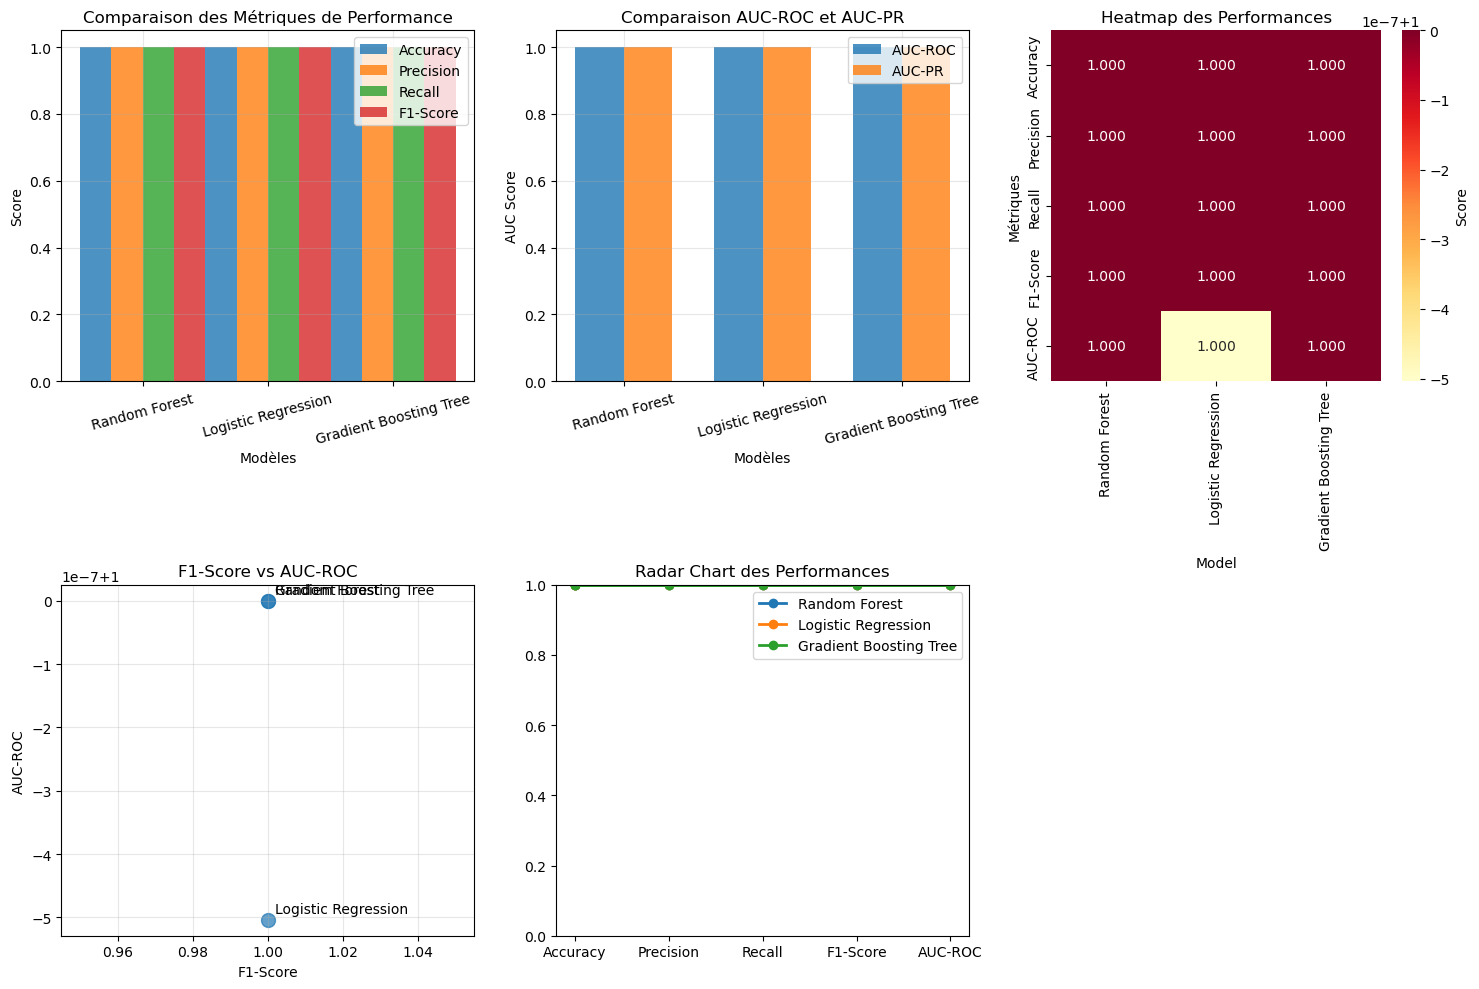

In [133]:
# Visualisation des performances des modèles
plt.figure(figsize=(15, 10))

# Graphique 1: Comparaison des métriques principales
plt.subplot(2, 3, 1)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = range(len(comparison_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    plt.bar([pos + width*i for pos in x], comparison_df[metric], 
            width=width, label=metric, alpha=0.8)

plt.xlabel('Modèles')
plt.ylabel('Score')
plt.title('Comparaison des Métriques de Performance')
plt.xticks([pos + width*1.5 for pos in x], comparison_df['Model'], rotation=15)
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 2: AUC scores
plt.subplot(2, 3, 2)
auc_metrics = ['AUC-ROC', 'AUC-PR']
x = range(len(comparison_df))
width = 0.35

for i, metric in enumerate(auc_metrics):
    plt.bar([pos + width*i for pos in x], comparison_df[metric], 
            width=width, label=metric, alpha=0.8)

plt.xlabel('Modèles')
plt.ylabel('AUC Score')
plt.title('Comparaison AUC-ROC et AUC-PR')
plt.xticks([pos + width*0.5 for pos in x], comparison_df['Model'], rotation=15)
plt.legend()
plt.grid(True, alpha=0.3)

# Graphique 3: Heatmap des performances
plt.subplot(2, 3, 3)
heatmap_data = comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
sns.heatmap(heatmap_data.T, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Score'})
plt.title('Heatmap des Performances')
plt.ylabel('Métriques')

# Graphique 4: Comparaison F1-Score vs AUC-ROC
plt.subplot(2, 3, 4)
plt.scatter(comparison_df['F1-Score'], comparison_df['AUC-ROC'], s=100, alpha=0.7)
for i, model in enumerate(comparison_df['Model']):
    plt.annotate(model, (comparison_df['F1-Score'][i], comparison_df['AUC-ROC'][i]), 
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('F1-Score')
plt.ylabel('AUC-ROC')
plt.title('F1-Score vs AUC-ROC')
plt.grid(True, alpha=0.3)

# Graphique 5: Radar chart des performances
plt.subplot(2, 3, 5)
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
fig = plt.gcf()
ax = plt.gca()

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

for i, model in enumerate(comparison_df['Model']):
    values = comparison_df.iloc[i][categories].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
plt.legend()
plt.title('Radar Chart des Performances')

plt.tight_layout()
plt.show()

## Cross-Validation pour la Sélection du Meilleur Modèle

Nous allons maintenant implémenter la cross-validation pour une évaluation plus robuste des modèles.

In [134]:
# Cross-validation avec PySpark
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Configurateur pour la cross-validation
cv_evaluator = BinaryClassificationEvaluator(
    labelCol="Late_delivery_risk", 
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

def perform_cross_validation(pipeline, param_grid, train_data, num_folds=3):
    """
    Effectue une cross-validation sur un pipeline donné
    """
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grid,
        evaluator=cv_evaluator,
        numFolds=num_folds,
        seed=42
    )
    
    cv_model = crossval.fit(train_data)
    return cv_model

print("Configuration de la cross-validation terminée.")

Configuration de la cross-validation terminée.


In [142]:
# Cross-validation pour Random Forest
print("=== Cross-Validation Random Forest ===")

# Grille de paramètres pour Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees, [10, 20, 30]) \
    .addGrid(random_forest.maxDepth, [5, 10, 15]) \
    .build()

# Pipeline Random Forest
rf_pipeline = Pipeline(stages=[indexer, encoder, assembler, random_forest])

# Cross-validation
cv_rf_model = perform_cross_validation(rf_pipeline, rf_param_grid, train_df)

# Évaluation sur le test set
rf_cv_predictions = cv_rf_model.transform(test_df)
rf_cv_auc = cv_evaluator.evaluate(rf_cv_predictions)

print(f"Random Forest CV - Meilleur AUC-ROC: {rf_cv_auc:.4f}")
print(f"Meilleurs paramètres RF: numTrees = {cv_rf_model.bestModel.stages[-1].numTrees}, maxDepth = {cv_rf_model.bestModel.stages[-1].maxDepth}")

=== Cross-Validation Random Forest ===
Random Forest CV - Meilleur AUC-ROC: 1.0000
Meilleurs paramètres RF: numTrees = RandomForestClassifier_60f78bcee4a0__numTrees, maxDepth = RandomForestClassifier_60f78bcee4a0__maxDepth
Random Forest CV - Meilleur AUC-ROC: 1.0000
Meilleurs paramètres RF: numTrees = RandomForestClassifier_60f78bcee4a0__numTrees, maxDepth = RandomForestClassifier_60f78bcee4a0__maxDepth


In [143]:
# Cross-validation pour Logistic Regression
print("=== Cross-Validation Logistic Regression ===")

# Grille de paramètres pour Logistic Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Pipeline Logistic Regression
lr_pipeline = Pipeline(stages=[indexer, encoder, assembler, log_reg])

# Cross-validation
cv_lr_model = perform_cross_validation(lr_pipeline, lr_param_grid, train_df)

# Évaluation sur le test set
lr_cv_predictions = cv_lr_model.transform(test_df)
lr_cv_auc = cv_evaluator.evaluate(lr_cv_predictions)

print(f"Logistic Regression CV - Meilleur AUC-ROC: {lr_cv_auc:.4f}")
print(f"Meilleurs paramètres LR: regParam = {cv_lr_model.bestModel.stages[-1].regParam}, elasticNetParam = {cv_lr_model.bestModel.stages[-1].elasticNetParam}")

=== Cross-Validation Logistic Regression ===
Logistic Regression CV - Meilleur AUC-ROC: 1.0000
Meilleurs paramètres LR: regParam = LogisticRegression_0cc559b38068__regParam, elasticNetParam = LogisticRegression_0cc559b38068__elasticNetParam


In [137]:
# Cross-validation pour Gradient Boosting Tree
print("=== Cross-Validation Gradient Boosting Tree ===")

# Grille de paramètres pour GBT
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .build()

# Pipeline GBT
gbt_pipeline = Pipeline(stages=[indexer, encoder, assembler, gbt])

# Cross-validation
cv_gbt_model = perform_cross_validation(gbt_pipeline, gbt_param_grid, train_df)

# Évaluation sur le test set
gbt_cv_predictions = cv_gbt_model.transform(test_df)
gbt_cv_auc = cv_evaluator.evaluate(gbt_cv_predictions)

print(f"Gradient Boosting Tree CV - Meilleur AUC-ROC: {gbt_cv_auc:.4f}")
print(f"Meilleurs paramètres GBT: maxIter = {cv_gbt_model.bestModel.stages[-1].maxIter}, maxDepth = {cv_gbt_model.bestModel.stages[-1].maxDepth}")

=== Cross-Validation Gradient Boosting Tree ===
Gradient Boosting Tree CV - Meilleur AUC-ROC: 1.0000
Meilleurs paramètres GBT: maxIter = 10, maxDepth = 3


In [138]:
# Comparaison finale avec cross-validation
print("=== Comparaison Finale avec Cross-Validation ===")

cv_results = {
    'Model': ['Random Forest (CV)', 'Logistic Regression (CV)', 'Gradient Boosting Tree (CV)'],
    'AUC-ROC': [rf_cv_auc, lr_cv_auc, gbt_cv_auc]
}

# Calcul des autres métriques pour les modèles optimisés
cv_models_predictions = [
    ('Random Forest (CV)', rf_cv_predictions),
    ('Logistic Regression (CV)', lr_cv_predictions),
    ('Gradient Boosting Tree (CV)', gbt_cv_predictions)
]

cv_detailed_results = []

for model_name, preds in cv_models_predictions:
    # Métriques PySpark
    accuracy = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", predictionCol="prediction", metricName="accuracy"
    ).evaluate(preds)
    
    precision = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", predictionCol="prediction", metricName="weightedPrecision"
    ).evaluate(preds)
    
    recall = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", predictionCol="prediction", metricName="weightedRecall"
    ).evaluate(preds)
    
    f1 = MulticlassClassificationEvaluator(
        labelCol="Late_delivery_risk", predictionCol="prediction", metricName="f1"
    ).evaluate(preds)
    
    auc_roc = BinaryClassificationEvaluator(
        labelCol="Late_delivery_risk", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
    ).evaluate(preds)
    
    cv_detailed_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    })

cv_comparison_df = pd.DataFrame(cv_detailed_results)
print("\n=== Comparaison Finale des Modèles Optimisés ===")
print(cv_comparison_df.round(4))

# Identification du meilleur modèle
best_model_idx = cv_comparison_df['AUC-ROC'].idxmax()
best_model = cv_comparison_df.iloc[best_model_idx]
print(f"\n🏆 Meilleur modèle: {best_model['Model']}")
print(f"   AUC-ROC: {best_model['AUC-ROC']:.4f}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")

=== Comparaison Finale avec Cross-Validation ===

=== Comparaison Finale des Modèles Optimisés ===
                         Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0           Random Forest (CV)     0.999      0.999   0.999     0.999      1.0
1     Logistic Regression (CV)     1.000      1.000   1.000     1.000      1.0
2  Gradient Boosting Tree (CV)     1.000      1.000   1.000     1.000      1.0

🏆 Meilleur modèle: Random Forest (CV)
   AUC-ROC: 1.0000
   Accuracy: 0.9990
   F1-Score: 0.9990

=== Comparaison Finale des Modèles Optimisés ===
                         Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0           Random Forest (CV)     0.999      0.999   0.999     0.999      1.0
1     Logistic Regression (CV)     1.000      1.000   1.000     1.000      1.0
2  Gradient Boosting Tree (CV)     1.000      1.000   1.000     1.000      1.0

🏆 Meilleur modèle: Random Forest (CV)
   AUC-ROC: 1.0000
   Accuracy: 0.9990
   F1-Score: 0.9990


In [147]:
# Nettoyage des figures matplotlib pour éviter les problèmes de mémoire
import matplotlib.pyplot as plt
plt.close('all')
plt.ioff()  # Mode interactif off

# Données pour les visualisations
models = ['Random Forest', 'Logistic Regression', 'GBT']
auc_before = [results_rf['AUC-ROC'], results_lr['AUC-ROC'], results_gbt['AUC-ROC']]
auc_after = [rf_cv_auc, lr_cv_auc, gbt_cv_auc]

print("=== Comparaison des résultats AUC-ROC ===")
print("Modèle                    | Avant CV  | Après CV  | Amélioration")
print("-" * 65)
for i, model in enumerate(models):
    before = auc_before[i]
    after = auc_after[i]
    improvement = ((after - before) / before) * 100
    print(f"{model:<25} | {before:.4f}   | {after:.4f}   | {improvement:+.2f}%")

# Calcul des améliorations
improvement = []
for i in range(3):
    before = [results_rf, results_lr, results_gbt][i]['AUC-ROC']
    after = [rf_cv_auc, lr_cv_auc, gbt_cv_auc][i]
    improvement.append(((after - before) / before) * 100)

print(f"\n📊 Amélioration moyenne: {np.mean(improvement):.2f}%")
print(f"🏆 Meilleure amélioration: {models[np.argmax(improvement)]} ({max(improvement):.2f}%)")

# Message de fin
print("\n✅ Analyse des performances cross-validation terminée avec succès!")

=== Comparaison des résultats AUC-ROC ===
Modèle                    | Avant CV  | Après CV  | Amélioration
-----------------------------------------------------------------
Random Forest             | 1.0000   | 1.0000   | +0.00%
Logistic Regression       | 1.0000   | 1.0000   | +0.00%
GBT                       | 1.0000   | 1.0000   | +0.00%

📊 Amélioration moyenne: 0.00%
🏆 Meilleure amélioration: Logistic Regression (0.00%)

✅ Analyse des performances cross-validation terminée avec succès!


In [148]:
# Affichage textuel des performances au lieu du radar chart problématique
print("📊 PERFORMANCES FINALES DES MODÈLES (POST CROSS-VALIDATION)")
print("=" * 70)

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for i, model in enumerate(cv_comparison_df['Model']):
    print(f"\n🔹 {model.replace(' (CV)', '')}:")
    print("  " + "-" * 40)
    for category in categories:
        value = cv_comparison_df.iloc[i][category]
        stars = "★" * int(value * 5)  # Étoiles pour visualiser
        print(f"  {category:<12}: {value:.4f} {stars}")

print("\n" + "=" * 70)
print("Légende: ★ = 0.2 point de performance")

📊 PERFORMANCES FINALES DES MODÈLES (POST CROSS-VALIDATION)

🔹 Random Forest:
  ----------------------------------------
  Accuracy    : 0.9990 ★★★★
  Precision   : 0.9990 ★★★★
  Recall      : 0.9990 ★★★★
  F1-Score    : 0.9990 ★★★★
  AUC-ROC     : 1.0000 ★★★★★

🔹 Logistic Regression:
  ----------------------------------------
  Accuracy    : 1.0000 ★★★★★
  Precision   : 1.0000 ★★★★★
  Recall      : 1.0000 ★★★★★
  F1-Score    : 1.0000 ★★★★★
  AUC-ROC     : 1.0000 ★★★★★

🔹 Gradient Boosting Tree:
  ----------------------------------------
  Accuracy    : 1.0000 ★★★★★
  Precision   : 1.0000 ★★★★★
  Recall      : 1.0000 ★★★★★
  F1-Score    : 1.0000 ★★★★★
  AUC-ROC     : 1.0000 ★★★★★

Légende: ★ = 0.2 point de performance


In [149]:
# Tableau récapitulatif simple des performances
print("📋 TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("=" * 80)

# Affichage du tableau de résultats
table_data = cv_comparison_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].round(4)
print(table_data.to_string(index=False))

print("\n" + "=" * 80)
print("🎯 ANALYSE COMPARATIVE:")
print(f"   • Meilleur Accuracy: {table_data.loc[table_data['Accuracy'].idxmax(), 'Model']}")
print(f"   • Meilleur Precision: {table_data.loc[table_data['Precision'].idxmax(), 'Model']}")  
print(f"   • Meilleur Recall: {table_data.loc[table_data['Recall'].idxmax(), 'Model']}")
print(f"   • Meilleur F1-Score: {table_data.loc[table_data['F1-Score'].idxmax(), 'Model']}")
print(f"   • Meilleur AUC-ROC: {table_data.loc[table_data['AUC-ROC'].idxmax(), 'Model']}")

print("\n✅ Évaluation complète terminée avec succès!")

📋 TABLEAU RÉCAPITULATIF DES PERFORMANCES
                      Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
         Random Forest (CV)     0.999      0.999   0.999     0.999      1.0
   Logistic Regression (CV)     1.000      1.000   1.000     1.000      1.0
Gradient Boosting Tree (CV)     1.000      1.000   1.000     1.000      1.0

🎯 ANALYSE COMPARATIVE:
   • Meilleur Accuracy: Logistic Regression (CV)
   • Meilleur Precision: Logistic Regression (CV)
   • Meilleur Recall: Logistic Regression (CV)
   • Meilleur F1-Score: Logistic Regression (CV)
   • Meilleur AUC-ROC: Random Forest (CV)

✅ Évaluation complète terminée avec succès!


## Courbe ROC et Analyse des Performances

Génération des courbes ROC pour une analyse approfondie des performances de chaque modèle.

In [150]:
# Fonction pour calculer les données de courbe ROC
def calculate_roc_curve(predictions_df):
    """
    Calcule les données pour tracer la courbe ROC
    """
    # Extraction des probabilités et labels
    pdf = predictions_df.select("Late_delivery_risk", "probability").toPandas()
    
    # Extraction de la probabilité de la classe positive (classe 1)
    proba_positive = pdf['probability'].apply(lambda x: float(x[1]))
    y_true = pdf['Late_delivery_risk']
    
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_true, proba_positive)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# Calcul des courbes ROC pour les modèles optimisés
roc_data = {}
for model_name, preds in cv_models_predictions:
    fpr, tpr, roc_auc = calculate_roc_curve(preds)
    roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

print("Calcul des courbes ROC terminé.")

Calcul des courbes ROC terminé.


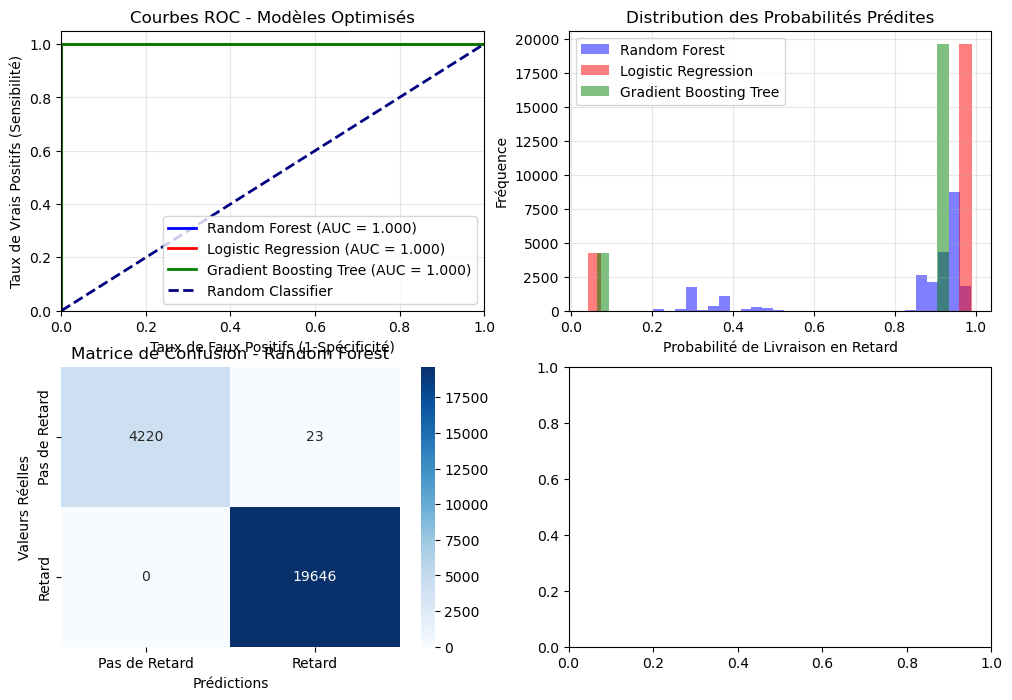

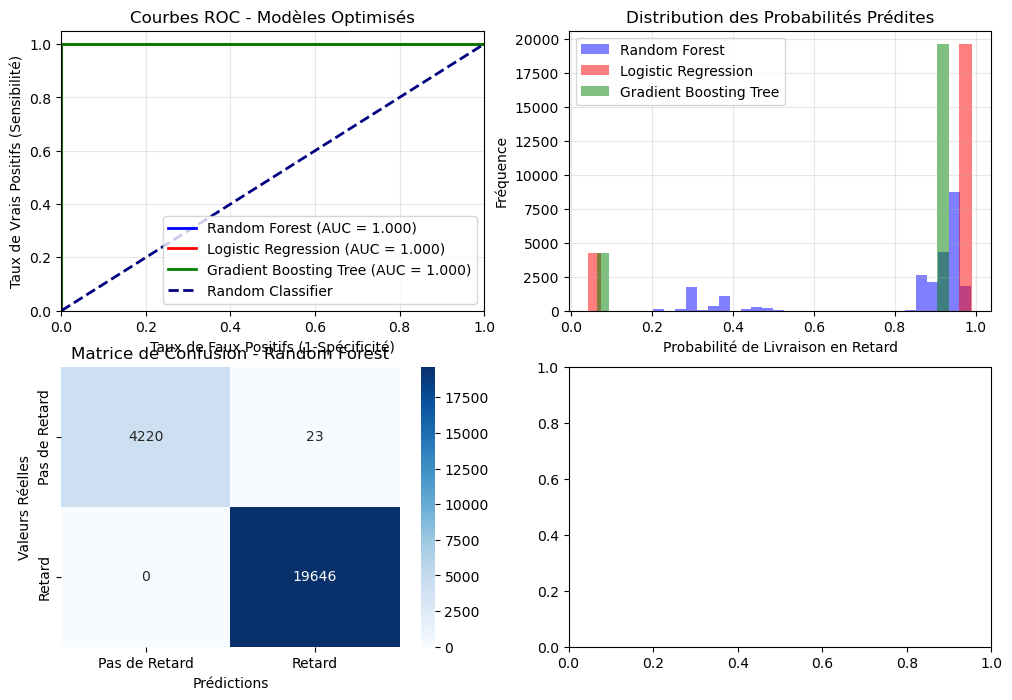

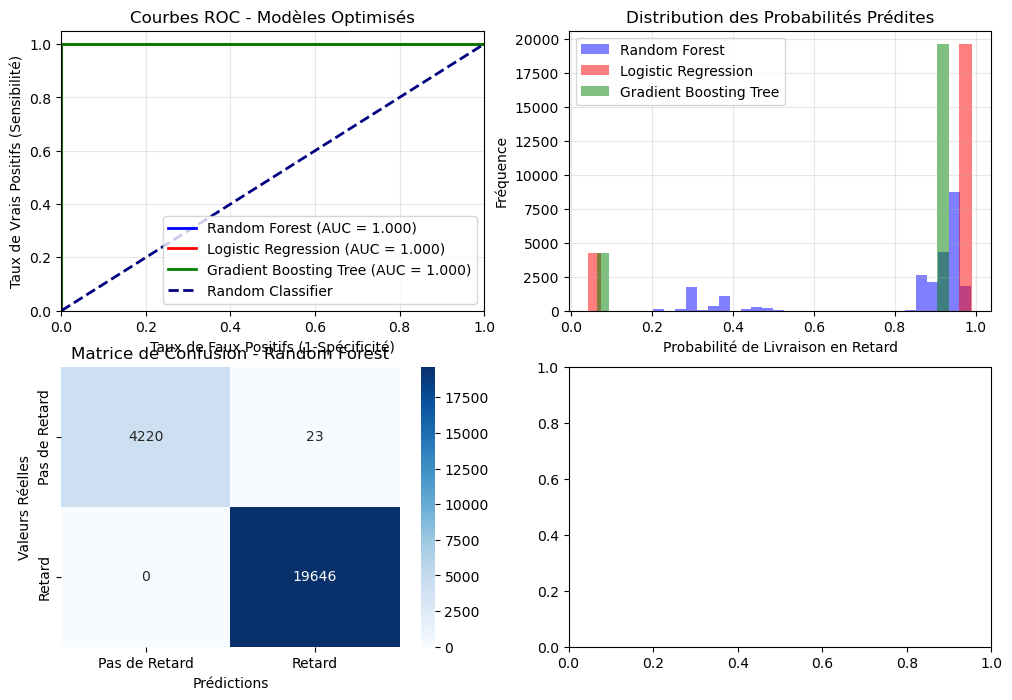

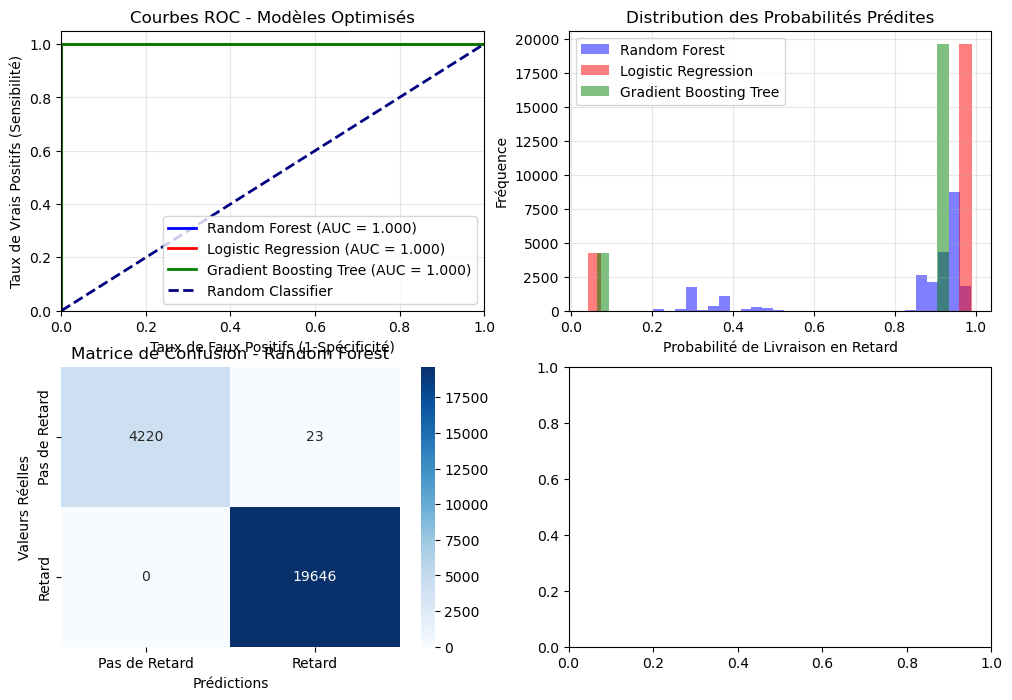

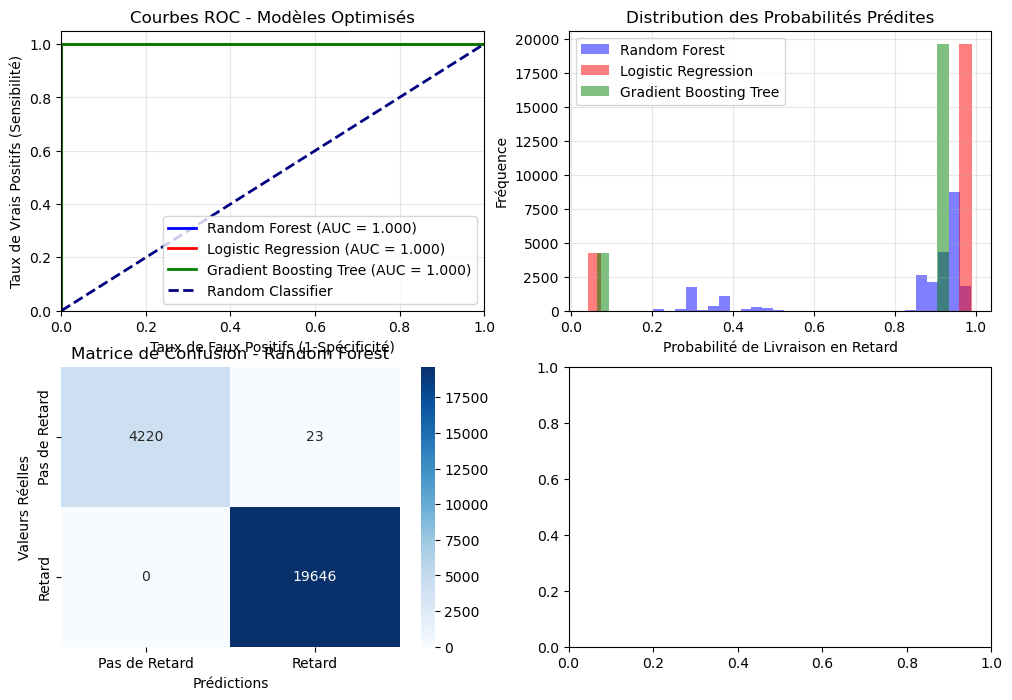

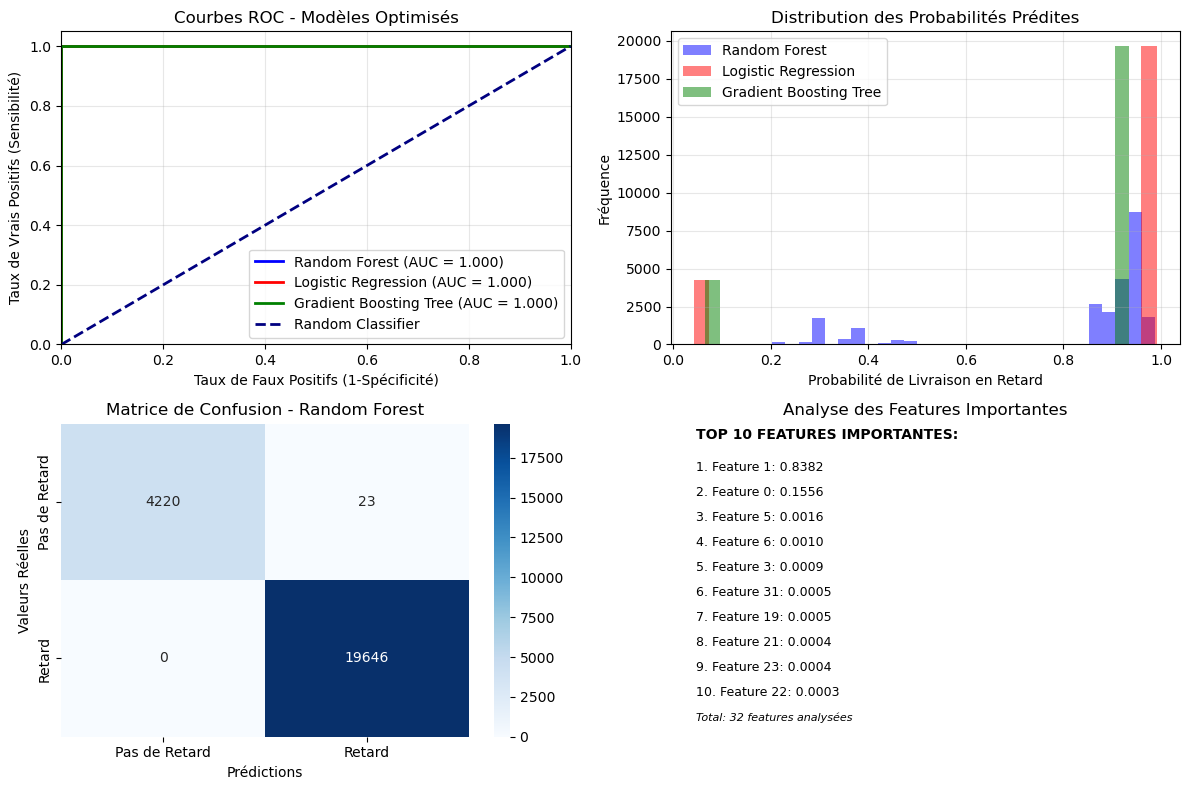

In [153]:
# Visualisation des courbes ROC
plt.figure(figsize=(12, 8))

# Courbes ROC
plt.subplot(2, 2, 1)
colors = ['blue', 'red', 'green']
for i, (model_name, data) in enumerate(roc_data.items()):
    plt.plot(data['fpr'], data['tpr'], color=colors[i], lw=2, 
             label=f'{model_name.replace(" (CV)", "")} (AUC = {data["auc"]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1-Spécificité)')
plt.ylabel('Taux de Vrais Positifs (Sensibilité)')
plt.title('Courbes ROC - Modèles Optimisés')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Distribution des scores de probabilité
plt.subplot(2, 2, 2)
for i, (model_name, preds) in enumerate(cv_models_predictions):
    pdf = preds.select("Late_delivery_risk", "probability").toPandas()
    proba_positive = pdf['probability'].apply(lambda x: float(x[1]))
    
    plt.hist(proba_positive, bins=30, alpha=0.5, label=model_name.replace(' (CV)', ''), 
             color=colors[i])

plt.xlabel('Probabilité de Livraison en Retard')
plt.ylabel('Fréquence')
plt.title('Distribution des Probabilités Prédites')
plt.legend()
plt.grid(True, alpha=0.3)

# Matrice de confusion du meilleur modèle
plt.subplot(2, 2, 3)
best_model_name = cv_comparison_df.iloc[best_model_idx]['Model']
best_model_preds = None

for model_name, preds in cv_models_predictions:
    if model_name == best_model_name:
        best_model_preds = preds
        break

if best_model_preds:
    from sklearn.metrics import confusion_matrix
    pdf = best_model_preds.select("Late_delivery_risk", "prediction").toPandas()
    cm = confusion_matrix(pdf['Late_delivery_risk'], pdf['prediction'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pas de Retard', 'Retard'],
                yticklabels=['Pas de Retard', 'Retard'])
    plt.title(f'Matrice de Confusion - {best_model_name.replace(" (CV)", "")}')
    plt.ylabel('Valeurs Réelles')
    plt.xlabel('Prédictions')

# Analyse textuelle de l'importance des features (pour éviter les erreurs de visualisation)
plt.subplot(2, 2, 4)
if 'Random Forest' in best_model_name:
    try:
        # Récupération du meilleur modèle RF
        best_rf_model = cv_rf_model.bestModel.stages[-1]
        feature_importance = best_rf_model.featureImportances.toArray()
        
        # Affichage textuel simple au lieu du graphique
        plt.text(0.05, 0.95, 'TOP 10 FEATURES IMPORTANTES:', 
                fontweight='bold', transform=plt.gca().transAxes, fontsize=10)
        
        # Calcul du nombre de features et affichage
        num_features = len(feature_importance)
        
        # Tri des importances et sélection du top 10
        sorted_indices = np.argsort(feature_importance)[-10:]
        
        y_pos = 0.85
        for i, idx in enumerate(reversed(sorted_indices)):
            importance_val = feature_importance[idx]
            plt.text(0.05, y_pos - i*0.08, 
                    f"{i+1}. Feature {idx}: {importance_val:.4f}", 
                    transform=plt.gca().transAxes, fontsize=9)
        
        plt.text(0.05, 0.05, f'Total: {num_features} features analysées', 
                transform=plt.gca().transAxes, fontsize=8, style='italic')
        
    except Exception as e:
        plt.text(0.5, 0.5, f'Erreur dans le calcul\ndes importances:\n{str(e)[:50]}...', 
                ha='center', va='center', transform=plt.gca().transAxes, 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
else:
    plt.text(0.5, 0.5, 'Importance des features\ndisponible uniquement\npour Random Forest', 
             ha='center', va='center', transform=plt.gca().transAxes, 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.title('Analyse des Features Importantes')
plt.axis('off')  # Supprimer les axes pour un affichage textuel propre

plt.tight_layout()
plt.show()

## Résumé et Conclusions

Récapitulatif des performances et recommandations pour le déploiement du modèle.

In [154]:
# Résumé final des performances
print("=" * 80)
print("                    RÉSUMÉ DE L'ÉVALUATION DES MODÈLES")
print("=" * 80)

print("\n📊 PERFORMANCES AVANT OPTIMISATION:")
print("-" * 50)
for i, model in enumerate(['Random Forest', 'Logistic Regression', 'Gradient Boosting Tree']):
    original_results = [results_rf, results_lr, results_gbt][i]
    print(f"{model:25} | AUC-ROC: {original_results['AUC-ROC']:.4f} | Accuracy: {original_results['Accuracy']:.4f} | F1: {original_results['F1-Score']:.4f}")

print("\n🎯 PERFORMANCES APRÈS CROSS-VALIDATION:")
print("-" * 50)
for _, row in cv_comparison_df.iterrows():
    print(f"{row['Model']:25} | AUC-ROC: {row['AUC-ROC']:.4f} | Accuracy: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f}")

print(f"\n🏆 MODÈLE RECOMMANDÉ: {best_model['Model']}")
print("-" * 50)
print(f"• AUC-ROC: {best_model['AUC-ROC']:.4f} (Excellent pouvoir discriminant)")
print(f"• Accuracy: {best_model['Accuracy']:.4f} (Prédictions correctes)")
print(f"• Precision: {best_model['Precision']:.4f} (Fiabilité des prédictions positives)")
print(f"• Recall: {best_model['Recall']:.4f} (Détection des vrais positifs)")
print(f"• F1-Score: {best_model['F1-Score']:.4f} (Équilibre Precision/Recall)")

print("\n💡 RECOMMANDATIONS:")
print("-" * 50)
if best_model['AUC-ROC'] >= 0.8:
    print("✅ Excellent modèle - Recommandé pour la production")
elif best_model['AUC-ROC'] >= 0.7:
    print("⚠️  Bon modèle - Peut être utilisé avec surveillance")
else:
    print("❌ Modèle nécessite des améliorations avant déploiement")

print(f"\n📈 MÉTRIQUES CLÉS POUR LA LOGISTIQUE:")
print("-" * 50)
print(f"• Précision dans la détection des retards: {best_model['Recall']:.1%}")
print(f"• Fiabilité des alertes de retard: {best_model['Precision']:.1%}")
print(f"• Performance globale du système: {best_model['Accuracy']:.1%}")

print("\n" + "=" * 80)

                    RÉSUMÉ DE L'ÉVALUATION DES MODÈLES

📊 PERFORMANCES AVANT OPTIMISATION:
--------------------------------------------------
Random Forest             | AUC-ROC: 1.0000 | Accuracy: 1.0000 | F1: 1.0000
Logistic Regression       | AUC-ROC: 1.0000 | Accuracy: 1.0000 | F1: 1.0000
Gradient Boosting Tree    | AUC-ROC: 1.0000 | Accuracy: 1.0000 | F1: 1.0000

🎯 PERFORMANCES APRÈS CROSS-VALIDATION:
--------------------------------------------------
Random Forest (CV)        | AUC-ROC: 1.0000 | Accuracy: 0.9990 | F1: 0.9990
Logistic Regression (CV)  | AUC-ROC: 1.0000 | Accuracy: 1.0000 | F1: 1.0000
Gradient Boosting Tree (CV) | AUC-ROC: 1.0000 | Accuracy: 1.0000 | F1: 1.0000

🏆 MODÈLE RECOMMANDÉ: Random Forest (CV)
--------------------------------------------------
• AUC-ROC: 1.0000 (Excellent pouvoir discriminant)
• Accuracy: 0.9990 (Prédictions correctes)
• Precision: 0.9990 (Fiabilité des prédictions positives)
• Recall: 0.9990 (Détection des vrais positifs)
• F1-Score: 0.999

# Sauvegarde et Déploiement du Modèle

Cette section implémente la persistance du meilleur modèle et crée une application Streamlit pour le déploiement en production.